# Домашняя работа: "Методы оптимизации"

ФИО: Тихонов Иван Андреевич

## Описание задания:
Вам необходимо реализовать оставшиеся методы оптимизации, которые разбирались на лекции: <b>Momentum, AdaDelta, Adam</b>. Сравнение методов оптимизации нужно провести на примере из семинара, а также при обучении сверточной нейронной сети на датасете MNIST.



## Задание разделено на следующие части:
1.1 Реализация методов Momentum, AdaDelta, Adam **(1 балл)**

1.2 Сравнение реализованных методов **(1 балл)**

2.1 Реализация сверточной нейронной сети и обучение ее на MNIST **(2 балла)**

2.2 Сравнение графиков обучения для нейросети на реализованных методах **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 17 декабря.

In [4]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

## Часть 1: Реализация методов

In [5]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

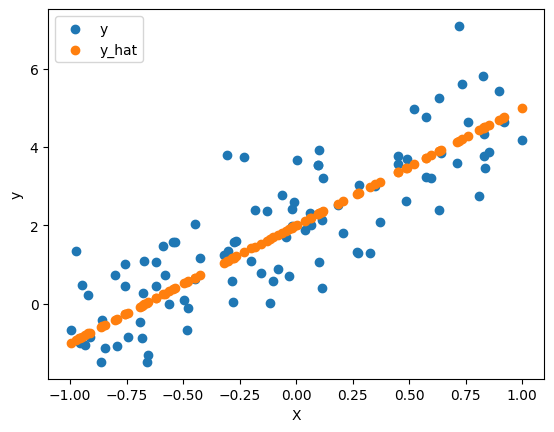

In [6]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

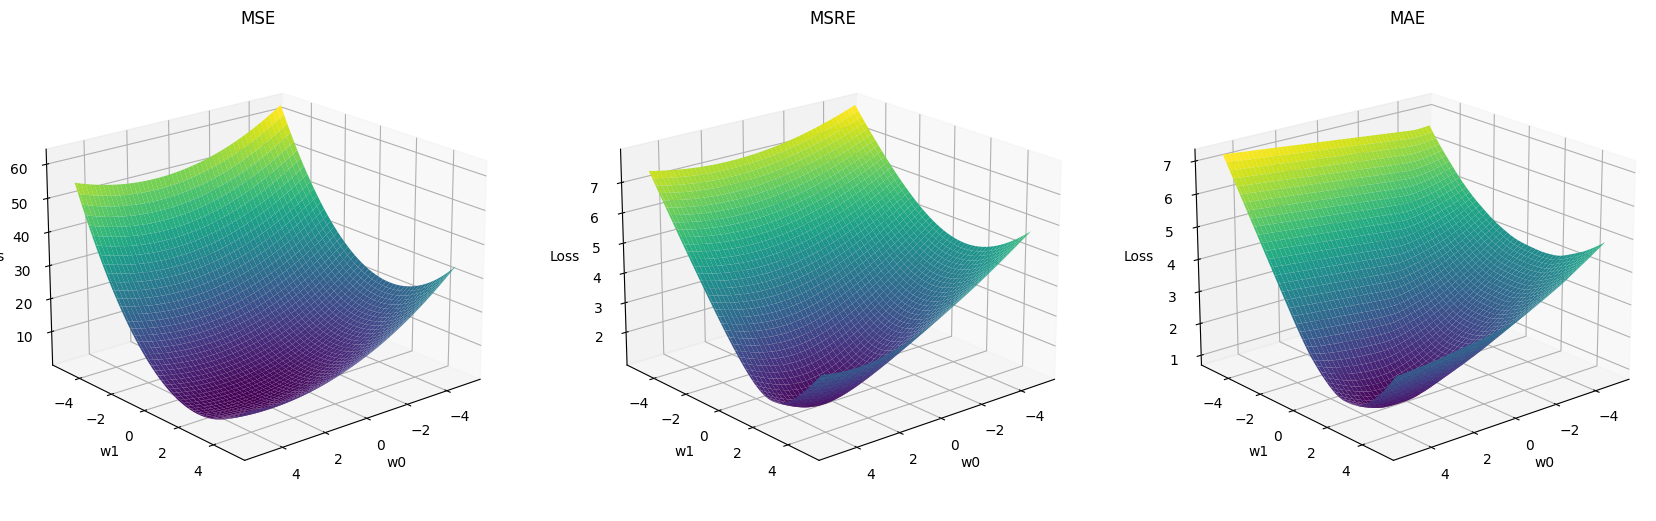

In [7]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [8]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [9]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [10]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализация методов SGD и AdaGrad с семинара:

In [20]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [21]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [0] * len(self.params)

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] += p.grad ** 2

                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

### 1.1 Реализуйте методы Momentum, AdaDelta, Adam. **(1 балл)**

#### Momentum
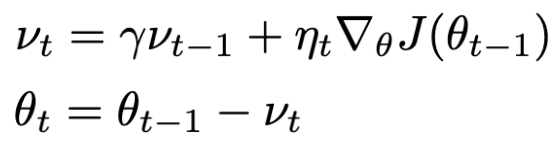

In [22]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9, device='cpu'):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.velocity = [torch.zeros_like(p, device=device) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.velocity[i] = self.gamma * self.velocity[i] + self.lr * p.grad
                p -= self.velocity[i]

#### AdaDelta
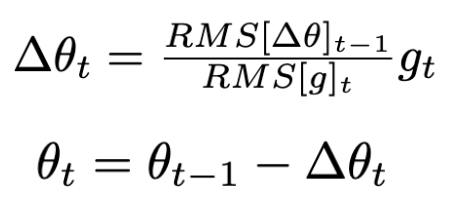

In [24]:
class AdaDelta(Optimizer):
    def __init__(self, params, eta=1e-8, gamma=0.9, device='cpu'):
        super().__init__(params)
        self.eta = eta
        self.gamma = gamma
        self.square_avg = [torch.zeros_like(p, device=device) for p in self.params]
        self.acc_delta = [torch.full_like(p, 1e-2, device=device) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.square_avg[i] = self.gamma * self.square_avg[i] + (1 - self.gamma) * p.grad ** 2

                rms_grad = torch.sqrt(self.square_avg[i] + self.eta)
                rms_delta = torch.sqrt(self.acc_delta[i] + self.eta)

                delta = (rms_delta / rms_grad) * p.grad
                p -= delta

                self.acc_delta[i] = self.gamma * self.acc_delta[i] + (1 - self.gamma) * delta ** 2

#### Adam
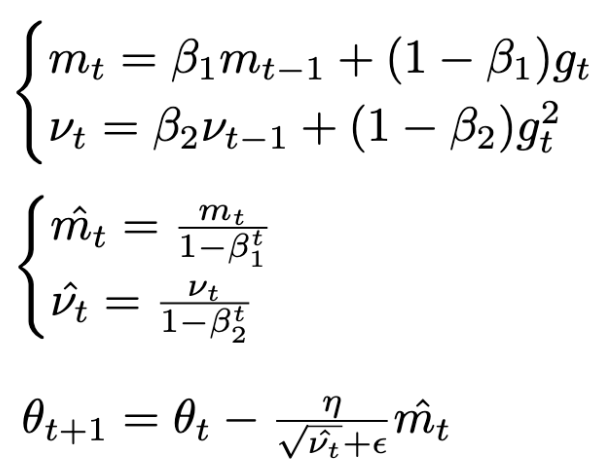

In [25]:
class Adam(Optimizer):
    def __init__(self, params, b1=0.9, b2=0.999, lr=1e-3, eps=1e-8, device='cpu'):
        super().__init__(params)
        self.b1 = b1
        self.b2 = b2
        self.lr = lr
        self.eps = eps
        self.m = [torch.zeros_like(p, device=device) for p in self.params]
        self.v = [torch.zeros_like(p, device=device) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                grad = p.grad
                self.m[i] = self.b1 * self.m[i] + (1 - self.b1) * grad
                self.v[i] = self.b2 * self.v[i] + (1 - self.b2) * grad ** 2

                m_hat = self.m[i] / (1 - self.b1 ** self.t)
                v_hat = self.v[i] / (1 - self.b2 ** self.t)

                p -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

### 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [26]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaDelta, {'eta': 1e-8}, start_point=[-4, -4], num_iter=100)

In [27]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {}],
        ['Momentum', Momentum, {}],
        ['AdaGrad', AdaGrad, {'eta':1e-1}],
        ['AdaDelta', AdaDelta, {'gamma':0.85}],
        ['Adam', Adam, {'lr': 1e-1, 'b1': 0.9, 'b2': 0.999}],
     ],
    start_point=[-4, -4],
    num_iter=100
)

##  Часть 2: Обучение нейронной сети

### 2.1 Реализуйте сверточную нейронную сеть и обучите ее на MNIST с помощью методов Adam, Adagrad, AdaDelta и SGD. Для обучения используйте оптимизаторы из первой части, а не из pytorch. **(2 балла)**

Скачайте датасет и реализуйте даталоудеры:

In [28]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2025-03-25 23:12:13--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2025-03-25 23:12:14--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [              <=>   ]  33.20M  10.6MB/s    in 3.1s    

2025-03-25 23:12:17 (10.6 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [29]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Реализуйте сверточную нейронную нейронную сеть по шаблону:

* Используйте сверточные (nn.Conv2d) и полносвязные (nn.Linear) слои
* Не забудьте преобразовать тензор перед подачей в полносвязный слой (x = x.view(-1, d1), где d1 -- размерность входа первого полносвязного слоя)
* Можно использовать dropout (nn.Dropout2d) и функции активации (например, F.relu)
* В конце метода forward необходимо использовать F.log_softmax для предсказания класса изображения

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [34]:
network = Net()
network.to(device)
optimizer = Adam(params=network.parameters(), lr=1e-2, device=device)

Запустите обучение, постройте график лоссов от эпохи:

In [36]:
losses = []

network.train()
for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data.to(device))
    loss = F.nll_loss(output, target.to(device))
    loss.backward()
    optimizer.step()


    if batch_idx % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        1, batch_idx * len(data), len(train_loader.dataset),
         100. * batch_idx / len(train_loader), loss.item()))
        losses.append(loss.item())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292749
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.485560
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.294051
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.241813
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.318924
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.454195
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.208839
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.583056
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.893696
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.460479
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.378368
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.598590
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.307076
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.202823
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.005783
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.475084
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.060321
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.224520
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.178184


### 2.2 Сравните графики обучения для нейросети на методах Adam, Adagrad, AdaDelta и SGD. **(1 балл)**

In [61]:
def train(model, optimize_name, optimize_method, params, train_dataloader, val_dataloader, device, n_epochs=10):
    optimizer = optimize_method(params=model.parameters(), **params)
    losses = []
    model.to(device)
    for epoch in tqdm(range(n_epochs)):

        model.train()
        for x_train, y_train in train_dataloader:
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        val_loss = []
        model.eval()
        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_pred = model(x_val).to(device)
                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.cpu().numpy())

        losses.append(np.mean(val_loss))
        
        print(f'Optimizer: {optimize_name} Epoch: {epoch}, loss: {np.mean(val_loss)}')
    return losses

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [63]:
optim_list = [
        ['AdaDelta', AdaDelta, {'gamma':0.3,'device':device}],
        ['SGD', SGD, {}],
        ['AdaGrad', AdaGrad, {'eta':1e-3}],
        ['Adam', Adam, {'lr': 1e-4, 'b1': 0.9, 'b2': 0.999, 'device':device}],
     ]
n_epochs = 10

In [64]:
losses = {}

for optimize_name, optimize_method, optim_params in optim_list:
  network = Net()
  loss = train(network, optimize_name, optimize_method, optim_params, train_loader, test_loader, device, n_epochs)
  losses[optimize_name] = loss

  0%|          | 0/10 [00:00<?, ?it/s]

Optimizer: AdaDelta Epoch: 0, loss: 2.30149245262146
Optimizer: AdaDelta Epoch: 1, loss: 2.3010668754577637
Optimizer: AdaDelta Epoch: 2, loss: 2.3010635375976562
Optimizer: AdaDelta Epoch: 3, loss: 2.3010947704315186
Optimizer: AdaDelta Epoch: 4, loss: 2.3010752201080322
Optimizer: AdaDelta Epoch: 5, loss: 2.3010518550872803
Optimizer: AdaDelta Epoch: 6, loss: 2.3010778427124023
Optimizer: AdaDelta Epoch: 7, loss: 2.3010361194610596
Optimizer: AdaDelta Epoch: 8, loss: 2.301009178161621
Optimizer: AdaDelta Epoch: 9, loss: 2.301053047180176


  0%|          | 0/10 [00:00<?, ?it/s]

Optimizer: SGD Epoch: 0, loss: 0.1494099199771881
Optimizer: SGD Epoch: 1, loss: 0.08505883812904358
Optimizer: SGD Epoch: 2, loss: 0.06157434359192848
Optimizer: SGD Epoch: 3, loss: 0.05015195906162262
Optimizer: SGD Epoch: 4, loss: 0.04202418401837349
Optimizer: SGD Epoch: 5, loss: 0.03921093791723251
Optimizer: SGD Epoch: 6, loss: 0.03532632812857628
Optimizer: SGD Epoch: 7, loss: 0.033377163112163544
Optimizer: SGD Epoch: 8, loss: 0.03240421414375305
Optimizer: SGD Epoch: 9, loss: 0.03014073334634304


  0%|          | 0/10 [00:00<?, ?it/s]

Optimizer: AdaGrad Epoch: 0, loss: 0.14376398921012878
Optimizer: AdaGrad Epoch: 1, loss: 0.10735557228326797
Optimizer: AdaGrad Epoch: 2, loss: 0.08896642923355103
Optimizer: AdaGrad Epoch: 3, loss: 0.0774896964430809
Optimizer: AdaGrad Epoch: 4, loss: 0.07119877636432648
Optimizer: AdaGrad Epoch: 5, loss: 0.0656217634677887
Optimizer: AdaGrad Epoch: 6, loss: 0.06246594712138176
Optimizer: AdaGrad Epoch: 7, loss: 0.05907226726412773
Optimizer: AdaGrad Epoch: 8, loss: 0.05590725317597389
Optimizer: AdaGrad Epoch: 9, loss: 0.05419272929430008


  0%|          | 0/10 [00:00<?, ?it/s]

Optimizer: Adam Epoch: 0, loss: 0.08066873252391815
Optimizer: Adam Epoch: 1, loss: 0.05565120279788971
Optimizer: Adam Epoch: 2, loss: 0.043829791247844696
Optimizer: Adam Epoch: 3, loss: 0.03681504353880882
Optimizer: Adam Epoch: 4, loss: 0.035431064665317535
Optimizer: Adam Epoch: 5, loss: 0.03286793828010559
Optimizer: Adam Epoch: 6, loss: 0.031216928735375404
Optimizer: Adam Epoch: 7, loss: 0.030612941831350327
Optimizer: Adam Epoch: 8, loss: 0.027458544820547104
Optimizer: Adam Epoch: 9, loss: 0.02949509210884571


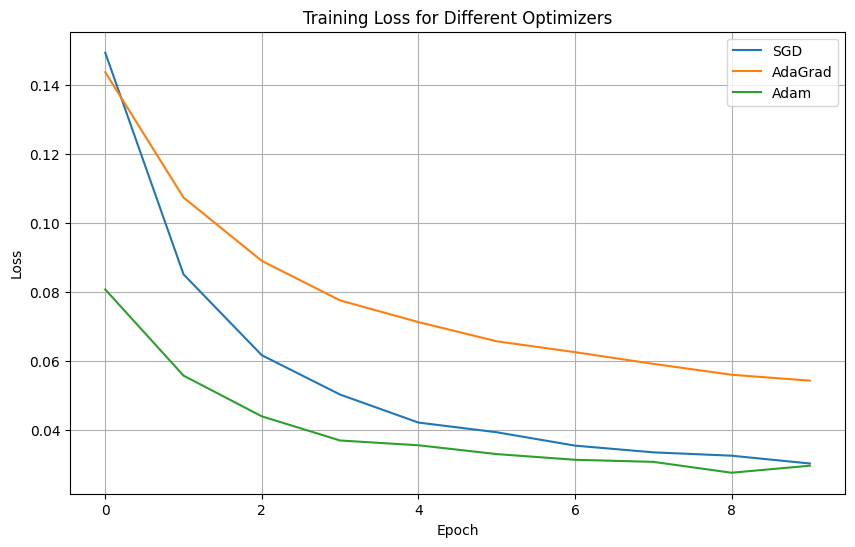

In [66]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

for optimizer_name, loss_values in losses.items():
    if optimizer_name != "AdaDelta":
        plt.plot(loss_values, label=optimizer_name)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Different Optimizers')
plt.legend()
plt.grid(True)
plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: